In [1]:
import os
import scipy
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.linear_model import LogisticRegression
from maxentropy import MinDivergenceModel

In [2]:
##Import Training Sample S

path = './data/house_debates_training/'
files = os.listdir(path)
D = {f[:-1] : {} for f in files}
for f in files:
    D[f[:-1]][f[-1]] = f
    S = {'e' : [], 'f' : []}
for pair in D:
    for language in D[pair]:
        sentences = open(path + pair + language, encoding = 'latin1').read().split('\n')
        sentences = sentences[[i for i in range(len(sentences)) if 'HANSARD' in sentences[i]][1] + 1:]
        for sentence in sentences:
            if language == 'e':
                s = 'NULL '
            else:
                s = ''
            S[language].append(s + sentence)

In [3]:
##Filter Bad Alignments

L = {'e' : [], 'f' : []}
for e, f in zip(S['e'], S['f']):
    if abs(len(e) - len(f)) <= 40:
        L['e'].append(e)
        L['f'].append(f)

In [3]:
##Count Vectorize
tp = '(?u)\\b\\w+\\b'
def cvec(S):
    cv = {'e' : CountVectorizer(token_pattern = tp), 'f' : CountVectorizer(token_pattern = tp)}
    for language in S:
        cv[language].fit(S[language])
    return cv

In [4]:
## One-Hot Vectorize

def ohvec(S, cv):
    analyzer = {'e' : cv['e'].build_analyzer(), 'f' : cv['f'].build_analyzer()}
    oh = {'e' : [], 'f' : []}
    for english, french in zip(S['e'], S['f']):
        e = analyzer['e'](english)
        f = analyzer['f'](french)
        oh['e'].append(cv['e'].transform(e).T)
        oh['f'].append(cv['f'].transform(f).T)
    return oh

In [5]:
## Words to Numbers

def numvec(S, cv):
    analyzer = {'e' : cv['e'].build_analyzer(), 'f' : cv['f'].build_analyzer()}
    oh = {'e' : [], 'f' : []}
    for english, french in zip(S['e'], S['f']):
        e = analyzer['e'](english)
        f = analyzer['f'](french)
        oh['e'].append([cv['e'].vocabulary_[word] for word in e])
        oh['f'].append([cv['f'].vocabulary_[word] for word in f])
    return oh

In [6]:
##Limit

def lim(S, l):
    return {language : S[language][:l] for language in S}

In [122]:
%%timeit
E @ (F.T / (E.T @ translation_1))

7.19 s ± 497 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
F.T / (E.T @ translation_1)

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [123]:
%%timeit
E @ scipy.sparse.csr_matrix(F.T / (E.T @ translation_1))

6.3 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [142]:
def IBM1(E, F, translation):
    with np.errstate(divide='ignore', invalid='ignore'):
        t = np.multiply(translation, E @ (F.T / (E.T @ translation)))
    t[~np.isfinite(t)] = 0
    t = normalize(t, 'l1')
    error = np.max(abs(translation_matrix - t))
    return (t, error)

In [16]:
def IBM2(E, F, translation, alignment):
    t = np.zeros(translation.shape)
    a = np.array([[np.zeros((m + 1, l + 1)) for l in range(alignment.shape[1])] 
                                            for m in range(alignment.shape[0])])
    for e, f in zip(E, F):
        m, l = len(f), len(e)
        for j in range(m):  
            denominator = translation[e, f[j]] @ alignment[m - 1, l - 1][j, :]
            for i in range(l):
                if translation[e[i], f[j]] and alignment[m - 1, l - 1][j, i]:
                    summand = translation[e[i], f[j]] * alignment[m - 1, l - 1][j, i] / denominator
                    t[e[i], f[j]] += summand
                    a[m - 1, l - 1][j, i] += summand
    t = normalize(t, 'l1')
    translation_error = np.max(abs(translation - t))
    alignment_error = np.zeros_like(alignment)
    for m in range(a.shape[0]):
        for l in range(a.shape[1]):
            if a[m, l].any():
                a[m, l] = normalize(a[m, l], 'l1')
                alignment_error[m, l] = np.max(abs(alignment[m, l] - a[m, l]))               
    alignment_error = np.max(alignment_error)
    return (t, a, translation_error, alignment_error)

In [103]:
def IBM3(E, F, translation, alignment, distortion, fertility, fertility0):
    t = np.zeros(translation.shape)
    d = np.array([[np.zeros((m + 1, l + 1)) for l in range(distortion.shape[1])] 
                                            for m in range(distortion.shape[0])])
    f = np.zeros(fertility.shape)
    f0 = np.zeros(fertility0.shape)
    
    for e, f in zip(E, F):
       m, l = len(f), len(e)
    

In [ ]:
def(E, F, translation, alignment, distortion)

In [138]:
def compute_IBM1(E, F, threshold):
    error = 1
    convergence = []
    translation = normalize(np.ones((E.shape[0], F.shape[0])), 'l1')
    while error > threshold:
        translation, error = IBM1(E, F, translation)
        convergence.append(error)
    plt.plot(convergence, color = 'r')
    plt.axhline(threshold, color = 'k')
    plt.show()
    return translation

In [14]:
def compute_IBM2(E, F, translation, threshold):
    translation_error = alignment_error = 1
    convergence = {'translation' : [], 'alignment' : []}
    L = max(len(e) for e in E)
    M = max(len(f) for f in F)
    t = translation.copy()
    a = np.array([[normalize(np.ones((m + 1, l + 1)), 'l1') for l in range(L)] for m in range(M)])
    while max(translation_error, alignment_error) > threshold:
        t, a, translation_error, alignment_error = IBM2(EN, FR, t, a)
        convergence['translation'].append(translation_error)
        convergence['alignment'].append(alignment_error)
    plt.plot(convergence['translation'], color = 'r')
    plt.plot(convergence['alignment'], color = 'b')
    plt.axhline(threshold, color = 'k')
    plt.show()
    return (t, a)

In [ ]:
def compute_IBM3(E, F, translation, alignment, threshold):
    L = max(len(e) for e in E)
    M = max(len(f) for f in F)
    t = translation.copy()
    a = np.array([[normalize(np.ones((m + 1, l + 1)), 'l1') for l in range(L)] for m in range(M)])
    while max(translation_error, alignment_error) > threshold:
        t, a, translation_error, alignment_error = IBM2(EN, FR, t, a)
        convergence['translation'].append(translation_error)
        convergence['alignment'].append(alignment_error)
    plt.plot(convergence['translation'], color = 'r')
    plt.plot(convergence['alignment'], color = 'b')
    plt.axhline(threshold, color = 'k')
    plt.show()
    return (t, a)

In [10]:
M = lim(S, 10_000)
cv = cvec(M)
E = cv['e'].transform(M['e']).T
F = cv['f'].transform(M['f']).T

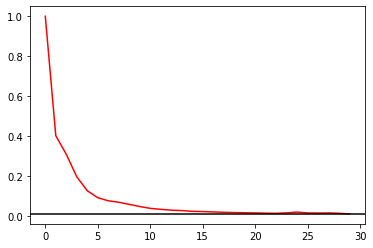

In [88]:
t = scipy.sparse.csr_matrix(compute_IBM1(E, F, 0.01))
scipy.sparse.save_npz('translation_IBM_1', t)

In [11]:
nm = numvec(M, cv)
EN = nm['e']
FR = nm['f']

In [3]:
translation = scipy.sparse.load_npz('./translation_IBM_1.npz')

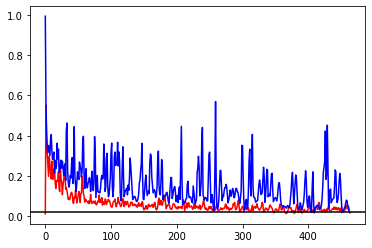

In [16]:
translation_2, alignment_2 = compute_IBM2(EN, FR, translation.toarray(), 0.02)
t = scipy.sparse.csr_matrix(translation_2)
scipy.sparse.save_npz('translation_IBM_2', t)
a = np.empty(alignment_2.shape, dtype = object)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a[i, j] = scipy.sparse.csr_matrix(alignment_2[i, j])
np.save('alignment_IBM_2', a)

In [7]:
translation_2 = scipy.sparse.load_npz('./translation_IBM_2.npz')
alignment_2 = np.load('./alignment_IBM_2.npy', allow_pickle = True)
translation_1 = scipy.sparse.load_npz('./translation_IBM_1.npz')

In [9]:
def translate_word(word, n, translation):
    word = word.lower()
    guess = []
    t = translation.toarray()
    finv = {cv['f'].vocabulary_[word] : word for word in cv['f'].vocabulary_}
    if not word in cv['e'].vocabulary_:
        return 'Not Found'
    word_id = cv['e'].vocabulary_[word]
    translations = t[word_id, :]
    for i in range(n):
        translated_id = np.argmax(translations)
        guess.append([finv[translated_id], t[word_id, translated_id]])
        translations[translated_id] = 0
    return pd.DataFrame(guess)

In [12]:
EN[100]
FR[100]
e = EN[100]
f = FR[100]

In [28]:
L = max(len(e) for e in EN)
M = max(len(f) for f in FR)
d = np.array([[normalize(np.ones((l + 1, m + 1)), 'l1') for m in range(M)] for l in range(L)])
ft = np.ones([L - 1, M])
ft = normalize(ft)
ft0 = 0.5

In [15]:
translation_2[e][:, f]

<45x47 sparse matrix of type '<class 'numpy.float64'>'
	with 730 stored elements in Compressed Sparse Row format>

In [29]:
m, l = len(f), len(e)
switch = np.zeros([len(e), len(f)])
swap = np.zeros([len(f), len(f)])
d = d[l - 1, m - 1]
t = translation_2[e][:, f]
fff = [alignment]

In [26]:
t.shape

(45, 47)

In [30]:
d.shape

(45, 47)

In [51]:
def Viterbi(e, f, translation, alignment):
    l = len(e)
    m = len(f)
    M = np.argmax(translation_2[e][:, f].multiply(alignment_2[m - 1, l - 1].T), axis = 0)
    return list(np.array(M)[0])

def hillclimb(e, f, translation, alignment, distortion, fertility, fertility0):
    m, l = len(f), len(e)
    switch = np.zeros([len(e), len(f)])
    swap = np.zeros([len(f), len(f)])
    d = distortion[m - 1, l - 1]
    t = translation_2[e][:, f]
    sa = Viterbi(e, f, translation, alignment)
    fff = [Viterbi.count(i) for i in range(1, l)]

In [49]:
v = Viterbi(e, f, translation_2, alignment_2)

In [43]:
r = np.array(v)[0]

In [50]:
v.count(3)

2

In [25]:
l = len(e)
m = len(f)

In [44]:
translation_2[e, f[0]]

<45x1 sparse matrix of type '<class 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [35]:
translation_2[e, f[0]].multiply(alignment_2[m - 1, l - 1][0, :].T)

<45x1 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [34]:
alignment_2[m - 1, l - 1][0, :].multiply(translation_2[e, f[0]])

<45x45 sparse matrix of type '<class 'numpy.float64'>'
	with 81 stored elements in Compressed Sparse Row format>

In [14]:
string = 'i'
print(translate_word(string, 5, translation_2))
print(translate_word(string, 5, translation_1))

    0             1
0  je  6.723765e-01
1   j  2.846594e-01
2  ai  4.096902e-02
3   c  1.995082e-03
4  il  5.530836e-12
     0         1
0   je  0.614381
1    j  0.249563
2   ai  0.133700
3  que  0.002341
4   le  0.000005


In [2]:
def guess(e, translation, alignment, epsilon):
    #Length
    Y = [0, 0]
    for p in epsilon:
        if p[0] == len(e):
            if epsilon[p] > Y[0]:
                Y = [epsilon[p], p[1]]
    length_g = Y[1]
    print(length_g)
    #Alignment
    a = []
    for j in range(length_g):
        A = np.array([alignment[(i, j, len(e), length_g)] for i in range(len(e))])
        a.append(np.argmax(A))
    print(a)
    #Words
    french_words = {p[1] for p in translation}
    F = []
    for j in range(length_g):
        M = [0, 'NULL']
        for f in french_words:
            if (tokenize(e)[a[j]], f) in translation:
                t = translation[(tokenize(e)[a[j]], f)] > M[0]
                if t > M[0]:
                    M = [t, f]
        F.append(f)
    print(F)

guess('Je suis ravi de vous rencontrer', t2, a2, ep)

NameError: name 't2' is not defined

In [132]:
##Language Model (Trigrams)

alpha = 0.0002

def ngrams(L, n):
    return [tuple(L[i:i+n]) for i in range(len(L) - n)]

def to_ngrams(S, n):
    T = []
    for e in S['e']:
        T = [*T, *ngrams(e, n)]
    return T

def LM(T):
    K = {}
    C = {}
    for t in T:
        K[t[:-1]] = 0
        C[t] = 0
    for t in T:
        K[t[:-1]] = K[t[:-1]] + 1
        C[t] = C[t] + 1
    return {t : C[t] / K[t[:-1]] for t in C}


def PLM(e, D):
    T = ngrams(e)
    return np.product(D[t] + 0.01 for t in T)